In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

第一部分 数据处理
1.加载数据

In [2]:
list_f = []
list_r = []
labels = []
list_a = []
list_all = []
f = open('clean_fake.txt',"r")
for line in f.readlines():
    list_f.append(line.strip('\n'))
    labels.append(0)
f.close()

f = open('clean_real.txt',"r")
for line in f.readlines():
    list_r.append(line.strip('\n'))
    labels.append(1)
f.close()

list_a = list_f +list_r
list_all = zip(list_a, labels)
df = pd.DataFrame(list_all, columns=['news', 'type'])
print(df)

                                                   news  type
0              trump warns of vote flipping on machines     0
1     this election is not about trump its about a g...     0
2     more on trump populism and how it can be contr...     0
3     trump bollywood ad meant to sway indian americ...     0
4     dems could be up on charges for inciting trump...     0
...                                                 ...   ...
3261  donald trump tells guam north korean threat a ...     1
3262                  abc news quiz trump golden globes     1
3263  cancel it trump says new air force one cost ri...     1
3264         trump trade policies easier said than done     1
3265  trumps voter fraud belief based on studies whi...     1

[3266 rows x 2 columns]


2.计算新闻中频数最高的十个词

In [3]:
from collections import Counter

def frequency(l):
    lines = []
    for i in l:
        w=i.split(' ')
        lines+=w
    #print(lines)
    list = Counter(lines).most_common(10)
    list_df = pd.DataFrame(list,columns=['words', 'frequency'])
    print(list_df)

print('假新闻中频数最高的10个单词')
fake_fre = frequency(list_f)
print(' ')
print('真新闻中频数最高的10个单词')
real_fre = frequency(list_r)
print(' ')
print('所有新闻中频数最高的10个单词')
all_fre = frequency(list_a)

假新闻中频数最高的10个单词
    words  frequency
0   trump       1328
1     the        439
2      to        409
3      in        231
4  donald        228
5      of        212
6     for        205
7       a        192
8     and        180
9      on        166
 
真新闻中频数最高的10个单词
    words  frequency
0   trump       1744
1  donald        829
2      to        413
3      us        230
4  trumps        219
5      in        214
6      on        205
7      of        186
8    says        178
9     for        174
 
所有新闻中频数最高的10个单词
    words  frequency
0   trump       3072
1  donald       1057
2      to        822
3     the        612
4      in        445
5      of        398
6     for        379
7      on        371
8     and        296
9       a        285


3.生成词向量

In [4]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

tfidfVecorizer = TfidfVectorizer(stop_words =ENGLISH_STOP_WORDS )
X= tfidfVecorizer.fit_transform(df['news'])
x_num=X.toarray()
print(x_num.shape)
print(x_num)
feature_words = tfidfVecorizer.get_feature_names()

(3266, 5585)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


4.划分数据集

In [5]:
from sklearn.model_selection import train_test_split

x_train,x, y_train,y = train_test_split(x_num,labels,test_size=0.3,train_size=0.7,random_state=0,stratify=labels)
x_test, x_val, y_test, y_val = train_test_split(x,y,test_size = 0.5,train_size =0.5,random_state=0,stratify=y)

print('训练集的大小为：',x_train.shape)
print('测试集的大小为：',x_test.shape)
print('验证集的大小为：',x_val.shape)

训练集的大小为： (2286, 5585)
测试集的大小为： (490, 5585)
验证集的大小为： (490, 5585)


第二部分 朴素贝叶斯算法

In [6]:
from sklearn import naive_bayes 
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
import sklearn.metrics
import random

1.使用验证集调参，找到最优的α值

In [7]:
alpha = [[random.uniform(0,1)] for i in range(1, 30)]
cv_scores = []

for i in alpha:
    clf = BernoulliNB(alpha=i,binarize=0.0, fit_prior=True)
    scores = cross_val_score(clf,x_val,y_val,cv =3,scoring = 'accuracy')
    cv_scores.append(scores.mean())  
    
max_index=cv_scores.index(max(cv_scores))
best_alpha=alpha[max_index]
print(best_alpha)

[0.09039715432237316]


2.在测试集和验证集上的结果

训练集上的准确率为：
 0.9715660542432196
 
训练集上的评估报告：
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       909
           1       0.98      0.98      0.98      1377

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286

 
测试集上的准确率为：
 0.8612244897959184
 
测试集上的评估报告：
               precision    recall  f1-score   support

           0       0.84      0.80      0.82       194
           1       0.87      0.90      0.89       296

    accuracy                           0.86       490
   macro avg       0.86      0.85      0.85       490
weighted avg       0.86      0.86      0.86       490

测试集的混淆矩阵:
 [[155  39]
 [ 29 267]]


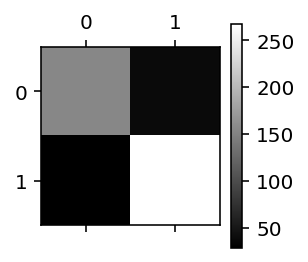

In [8]:
from sklearn.metrics import confusion_matrix
clf_nb = BernoulliNB(alpha=best_alpha,binarize=0.0, fit_prior=True)
clf_nb.fit(x_train,y_train)
predicted=clf_nb.predict(x_train)
prediction=clf_nb.predict(x_test)
#混淆矩阵
cm = confusion_matrix(y_test, prediction)

print('训练集上的准确率为：\n',sklearn.metrics.accuracy_score(y_train,predicted))
print(' ')
print('训练集上的评估报告：\n',sklearn.metrics.classification_report(y_train,predicted))
print(' ')
print('测试集上的准确率为：\n',sklearn.metrics.accuracy_score(y_test,prediction))
print(' ')
print('测试集上的评估报告：\n',sklearn.metrics.classification_report(y_test,prediction))
print("测试集的混淆矩阵:\n", cm)

# 混淆矩阵可视化
plt.figure(figsize=(2, 2), dpi=144)
ax = plt.gca()  # Get Current Axes
ax.spines['right'].set_color('none')  # ax.spines是数据区域的边界
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.xaxis.set_ticks_position('none')  # 删除轴上的刻度点
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.matshow(cm, fignum=1, cmap='gray')  # plt.matshow专门用于矩阵可视化
plt.colorbar()  # 添加渐变色条
plt.show()

3.输出新的频数最高的十个单词

In [9]:
list_0=[]
list_1=[]
list_0=clf_nb.feature_log_prob_[0]
list_1=clf_nb.feature_log_prob_[1]
feature_list0=[]
feature_list1=[]
result_ten_list0=[]
result_ten_list1=[]

print('处理后，假新闻标题中频数最高的10个单词')
feature_list0=sorted(zip(list_0,feature_words),reverse=True)
for i,j in feature_list0[2:16]:
    result_ten_list0.append(j)
result_ten_list0.remove('says')
result_ten_list0.remove('clinton')
result_ten_list0.remove('election')
result_ten_list0.remove('president')
print(result_ten_list0)   
print('')
print('处理后，真新闻标题中频数最高的10个单词')
feature_list1=sorted(zip(list_1,feature_words),reverse=True)
for i,j in feature_list1[2:16]:
    result_ten_list1.append(j)
result_ten_list1.remove('says')
result_ten_list1.remove('clinton')
result_ten_list1.remove('election')
result_ten_list1.remove('president')
print(result_ten_list1)

处理后，假新闻标题中频数最高的10个单词
['hillary', 'just', 'obama', 'new', 'america', 'victory', 'news', 'win', 'campaign', 'supporters']

处理后，真新闻标题中频数最高的10个单词
['trumps', 'ban', 'north', 'russia', 'korea', 'white', 'turnbull', 'house', 'deal', 'wall']


第三部分 逻辑回归

1.生成新的词向量

In [10]:
x_num[x_num>0] = 1
x_train2,x2, y_train2,y2 = train_test_split(x_num,labels,test_size=0.3,train_size=0.7,random_state=0,stratify=labels)
x_test2, x_val2, y_test2, y_val2 = train_test_split(x2,y2,test_size = 0.5,train_size =0.5,random_state=0,stratify=y2)

2.找到最优参数C

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline
from sklearn.model_selection import GridSearchCV

lr_model = LogisticRegression(solver='lbfgs') 
pl = pipeline.Pipeline([('lr', lr_model)])
param_grid = {'lr__C': [0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]}

# 网格搜索模型（Grid Search Model）初始化
model = GridSearchCV(estimator=pl, param_grid=param_grid, scoring='roc_auc', cv=6)

# fit网格搜索模型
model.fit(x_val2, y_val2)
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.858
Best parameters set:
	lr__C: 3


3.评估模型

In [12]:
clf_lr=LogisticRegression(penalty='l2', C=3,solver='liblinear')
clf_lr.fit(x_train2,y_train2)
predicted2=clf_lr.predict(x_train2)
prediction2=clf_lr.predict(x_test2)

print("训练集上的正确率：")
print(sklearn.metrics.accuracy_score(predicted2, y_train2))
print(' ')
print('训练集上的评估报告：\n',sklearn.metrics.classification_report(y_train2,predicted2))
print(' ')
print("测试集上的正确率：")
print(sklearn.metrics.accuracy_score(prediction2, y_test2))
print(' ')
print('测试集上的评估报告：\n',sklearn.metrics.classification_report(y_test2,prediction2))

训练集上的正确率：
0.9916885389326334
 
训练集上的评估报告：
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       909
           1       0.99      0.99      0.99      1377

    accuracy                           0.99      2286
   macro avg       0.99      0.99      0.99      2286
weighted avg       0.99      0.99      0.99      2286

 
测试集上的正确率：
0.8244897959183674
 
测试集上的评估报告：
               precision    recall  f1-score   support

           0       0.85      0.68      0.75       194
           1       0.81      0.92      0.86       296

    accuracy                           0.82       490
   macro avg       0.83      0.80      0.81       490
weighted avg       0.83      0.82      0.82       490



4.ROC和AUC

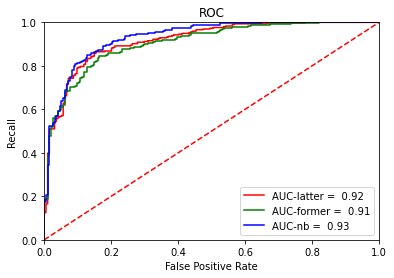

In [13]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y_test_n2 = class_le.fit_transform(y_test2)
predictions_pro2 = clf_lr.predict_proba(x_test2)
false_positive_rate2, recall2, thresholds2 = sklearn.metrics.roc_curve(y_test_n2,predictions_pro2[:,1])
roc_auc2 = sklearn.metrics.auc(false_positive_rate2, recall2)
plt.plot(false_positive_rate2, recall2, 'r', label='AUC-latter = % 0.2f' % roc_auc2)

y_test_n = class_le.fit_transform(y_test)
predictions_pro = clf_lr.predict_proba(x_test)
false_positive_rate, recall, thresholds = sklearn.metrics.roc_curve(y_test_n,predictions_pro[:,1])
roc_auc = sklearn.metrics.auc(false_positive_rate, recall)
plt.plot(false_positive_rate, recall, 'g', label='AUC-former = % 0.2f' % roc_auc)

predictions_pro3 = clf_nb.predict_proba(x_test)
false_positive_rate3, recall3, thresholds3 = sklearn.metrics.roc_curve(y_test_n,predictions_pro3[:,1])
roc_auc3 = sklearn.metrics.auc(false_positive_rate3, recall3)
plt.plot(false_positive_rate3, recall3, 'b', label='AUC-nb = % 0.2f' % roc_auc3)

plt.title('ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.show()

第四部分 决策树

1.找到最优参数

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree

dt_model = DecisionTreeClassifier()
param_grid={'criterion':['gini','entropy'],'max_depth':[5,10,15,20,25,30,35,40,45,50]}
model2 = GridSearchCV(dt_model, param_grid, cv=6,  scoring='roc_auc')
model2.fit(x_val,y_val)  
model2.best_params_

{'criterion': 'gini', 'max_depth': 30}

2.决策树及其结果

In [15]:
clf_dt = DecisionTreeClassifier(criterion='gini',max_depth=30)
clf_dt.fit(x_train,y_train)
predicted3 = clf_dt.predict(x_train)
prediction3 = clf_dt.predict(x_test)

print("训练集上的正确率：")
print(sklearn.metrics.accuracy_score(predicted3, y_train))
print(' ')
print('训练集上的评估报告：\n',sklearn.metrics.classification_report(y_train,predicted3))
print(' ')
print("测试集上的正确率：")
print(sklearn.metrics.accuracy_score(prediction3, y_test))
print(' ')
print('测试集上的评估报告：\n',sklearn.metrics.classification_report(y_test,prediction3))

训练集上的正确率：
0.9243219597550306
 
训练集上的评估报告：
               precision    recall  f1-score   support

           0       1.00      0.81      0.90       909
           1       0.89      1.00      0.94      1377

    accuracy                           0.92      2286
   macro avg       0.94      0.91      0.92      2286
weighted avg       0.93      0.92      0.92      2286

 
测试集上的正确率：
0.7510204081632653
 
测试集上的评估报告：
               precision    recall  f1-score   support

           0       0.75      0.56      0.64       194
           1       0.75      0.88      0.81       296

    accuracy                           0.75       490
   macro avg       0.75      0.72      0.72       490
weighted avg       0.75      0.75      0.74       490



3.提取并可视化决策树前两层

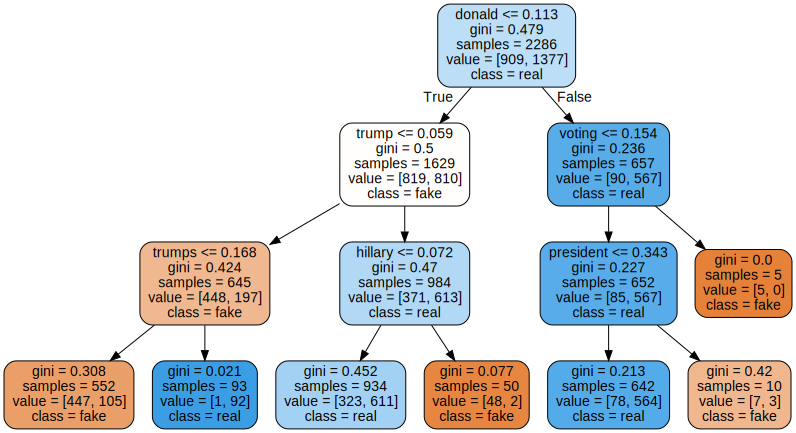

In [16]:
import pydot
import pydotplus
from sklearn.tree import export_graphviz
import graphviz

t1=clf_dt.fit(x_train,y_train)
with open("decision_tree.dot", 'w') as f:
    f = tree.export_graphviz(clf_dt,
                             out_file = f,
                             feature_names= feature_words,
                             class_names=['fake','real'],
                             filled=True,
                             rounded=True)
os.system('dot -Tjpg decision_tree.dot -o decision_tree.jpg')

clf_dtg = DecisionTreeClassifier(criterion='gini',max_depth=3)
t2=clf_dtg.fit(x_train,y_train)
dot_data = tree.export_graphviz(t2,feature_names= feature_words,class_names=['fake','real'],filled=True,rounded=True)
graph = graphviz.Source(dot_data)
graph

#with open("tree2.dot", 'w') as f:
#    f = tree.export_graphviz(clf_dt,out_file = f,feature_names= feature_words,class_names=['fake','real'],filled=True,rounded=True)
#os.system('dot -Tjpg tree2.dot -o decision_tree.jpg')'''

In [20]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=100)
#newX = pca.fit_transform(x_train)
#print(pca.explained_variance_ratio_)

第五部分 其他模型

1.被动感知算法

In [17]:
from sklearn.linear_model import PassiveAggressiveClassifier
clf_pac=PassiveAggressiveClassifier(max_iter=100, random_state=0,tol=1e-3)
clf_pac.fit(x_train,y_train)
predicted4 = clf_pac.predict(x_train)
prediction4 = clf_pac.predict(x_test)

print("训练集上的正确率：")
print(sklearn.metrics.accuracy_score(predicted4, y_train))
print(' ')
print("测试集上的正确率：")
print(sklearn.metrics.accuracy_score(prediction4, y_test))

训练集上的正确率：
1.0
 
测试集上的正确率：
0.8428571428571429


2.SVM

In [18]:
from sklearn import svm
svm = svm.SVC()
svm.fit(x_train,y_train)
predicted5 = svm.predict(x_train)
prediction5 = svm.predict(x_test)

print("训练集上的正确率：")
print(sklearn.metrics.accuracy_score(predicted5, y_train))
print(' ')
print("测试集上的正确率：")
print(sklearn.metrics.accuracy_score(prediction5, y_test))

训练集上的正确率：
0.9934383202099738
 
测试集上的正确率：
0.8469387755102041


3.随机森林

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=300,criterion='gini',max_features=100)
clf_rf.fit(x_train,y_train)
predicted6 = clf_rf.predict(x_train)
prediction6 = clf_rf.predict(x_test)

print("训练集上的正确率：")
print(sklearn.metrics.accuracy_score(predicted6, y_train))
print(' ')
print("测试集上的正确率：")
print(sklearn.metrics.accuracy_score(prediction6, y_test))

训练集上的正确率：
1.0
 
测试集上的正确率：
0.8530612244897959


4.MLP

In [21]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='lbfgs')
clf_mlp.fit(x_train,y_train)
predicted7 = clf_mlp.predict(x_train)
prediction7 = clf_mlp.predict(x_test)

print("训练集上的正确率：")
print(sklearn.metrics.accuracy_score(predicted7, y_train))
print(' ')
print("测试集上的正确率：")
print(sklearn.metrics.accuracy_score(prediction7, y_test))

训练集上的正确率：
1.0
 
测试集上的正确率：
0.8428571428571429
